# Assignment 10: Clustering

Only use the already imported libraries numpy and matplotlib as well as the Python standard library.

- *Put your names here*

**Indicate here whether you want to present.*

In [202]:
# Load required packages and dataset. Do not modify.
import matplotlib.pyplot as plt
import numpy as np


def load_iris_dataset():
    from sklearn import datasets
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target
    return X, y
    
X, y = load_iris_dataset()

## Task 1: Expectation Maximization for Gaussian Mixture

1. Implement the expectation maximization algorithm for Gaussian mixtures as presented in the lecture. Choose random samples to initialize the model parameters for each cluster. Your algorithm can be limited to the 1-dimensional case, which is shown in the example of the lecture.

2. Compute the clustering for any single feature of the Iris dataset. Plot your results and compare them visually to the actual classification labels.

In [218]:
class GaussianMixtureEM(object):
    def __init__(self, n_components, max_iter=100):
        self.n_components = n_components  # Number of Gaussian distributions that make up the mixture
    
        self.mean = None
        self.var = None
        
        self.max_iter = 100
        self.required_iter = 0
        
    def fit(self, X):
        assert len(X.shape) == 1  # ensure that X is one-dimensional
        
        self.required_iter = 0
        
        # Initialize model.
        # Use random samples from X to initialize means.
        self.mean = np.random.choice(X, (self.n_components,), replace=False)
        self.var = np.array([np.mean((X - self.mean[cid])**2) for cid in range(self.n_components)])        
        
        prev_likelihood = None
        
        # Iterate until convergence or maximum number of iterations.
        for _ in range(self.max_iter):            
            # Expectation: How probable are current model parameters for X
            density = np.zeros((X.shape[0], self.n_components)) 
            z = np.zeros((X.shape[0], self.n_components))  # weights
            for cid in range(self.n_components):
                density[:, cid] = self._density(X, cid)
                z[:, cid] = density[:, cid] / np.sum(density[:, cid])
                
            # Log-Likelihood: Is the algorithm converging?
            # I use proportional change in likelihood to identify convergence.
            likelihood = np.sum(np.log(np.sum(z*density, axis=1)))
            if prev_likelihood and (np.abs(prev_likelihood - likelihood) / np.abs(prev_likelihood) < 0.01):
                print('Finished training due to convergence.')
                break
            prev_likelihood = likelihood

            # Maximization: Update model parameters based new weights
            for cid in range(self.n_components):
                self.var[cid] = np.sum(z[:, cid] * (X - self.mean[cid])**2) / np.sum(z[:, cid])
                self.mean[cid] = np.sum(z[:, cid] * X) / np.sum(z[:, cid])
                
            self.required_iter += 1
                            
    def predict(self, X):
        # Number the clusters from 0 to n_components-1.
        # Return the cluster label assignments for each sample in X as a vector.
        density = np.zeros((X.shape[0], self.n_components))
        for cid in range(self.n_components):
            density[:, cid] = self._density(X, cid)
        return np.argmax(density, axis=1)
            
    def _density(self, X, cid):
        a = 1/np.sqrt(2*np.pi*self.var[cid])
        b = np.exp(-np.power(X - self.mean[cid], 2)/(2*self.var[cid]))
        return  a * b
    

Finished training due to convergence.


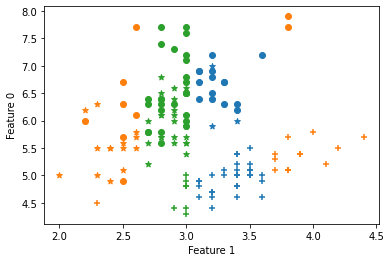

In [234]:
feature_idx = 1
other_feature_idx = 0

gm = GaussianMixtureEM(3)
gm.fit(X[:, feature_idx])
clusters = gm.predict(X[:, feature_idx])

colors = ['C0', 'C1', 'C2']
markers = ['+', '*', 'o']

fig, ax = plt.subplots()
for i, (x1, x2) in enumerate(zip(X[:, feature_idx], X[:, other_feature_idx])):
    ax.scatter([x1], [x2], c=colors[clusters[i]], marker=markers[y[i]])
ax.set_xlabel(f'Feature {feature_idx}')
ax.set_ylabel(f'Feature {other_feature_idx}');

## Task 2: Metrics
In this task, you will implement the silhoutte coefficient as an intrinsic evaluation measure and purity as an extrinsic evaluation measure. You will use these metrics to evaluate the [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) model implemented in scikit-learn.

1. Implement the silhouette coefficient.
2. Implement purity.
3. Compute both metrics for different `n_components`. Plot the results.


In [33]:
def silhouette(X, cluster_labels):
    """
    X.shape = (N, D), where N is the number of samples and D is the number of input features.
    cluster_labels.shape = (N,)
    """
    N = X.shape[0]
    n_clusters = np.max(cluster_labels) + 1
    s = np.zeros((N,))
    for i in range(N):
        same_cluster = X[cluster_labels == cluster_labels[i]]
        ai = 1/(N-1) * np.sum(np.sqrt(np.sum(np.power(X[i] - same_cluster, 2), axis=1)))
        
        bi = np.inf
        for clabel in range(n_clusters):
            if clabel == cluster_labels[i]:
                continue
                
            other_cluster = X[cluster_labels == clabel]
            di = np.mean(np.sqrt(np.sum(np.power(X[i] - other_cluster, 2), axis=1)))
            if di < bi:
                bi = di
            
        s[i] = (bi - ai) / max(ai, bi)
        
    return np.mean(s)

def purity(X, y, cluster_labels):
    """
    y are the true class labels, while cluster_labels are the labels automatically assigned during clustering.
    """
    N = X.shape[0]
    n_clusters = np.max(cluster_labels) + 1
    
    return 1/N * np.sum([np.max(np.bincount(y[cluster_labels == j])) for j in range(n_clusters)])


In [28]:
from sklearn.mixture import GaussianMixture

s = []
p = []

n_components = list(range(2, 32, 2))

for n in n_components:
    mixture = GaussianMixture(n_components=n)
    mixture.fit(X)
    cluster_labels = mixture.predict(X)
    s.append(silhouette(X, cluster_labels))
    p.append(purity(X, y, cluster_labels))


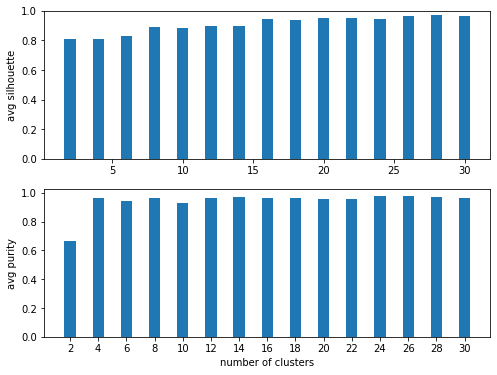

In [34]:
fig, ax = plt.subplots(2, figsize=(8, 6))
ax[0].bar(n_components, s)
ax[1].bar(n_components, p)
ax[0].set_ylabel('avg silhouette')
ax[1].set_ylabel('avg purity')
ax[1].set_xlabel('number of clusters')
ax[0].set_ylim((0.0, 1.0))
ax[1].set_xticks(n_components);